# Training two-layer CNN for cifar10.

## Load data

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import sklearn.model_selection
import sklearn.metrics
from tqdm import tqdm
from IPython.display import clear_output
import seaborn as sns
import copy
import random
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(SEED)
g = torch.Generator()
g.manual_seed(SEED)

In [3]:
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:02<00:00, 85148849.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Split dataset and define dataloaders

In [4]:
torch.manual_seed(42)

TRAIN_SIZE = 40_000
VAL_SIZE = 10_000
TEST_SIZE = 10_000

BATCH_SIZE = 32
NUM_WORKERS = 2

train, val, _ = torch.utils.data.random_split(train_set, [TRAIN_SIZE, VAL_SIZE, len(train_set) - (TRAIN_SIZE + VAL_SIZE)])
test, _ = torch.utils.data.random_split(test_set, [TEST_SIZE, len(test_set) - TEST_SIZE])

train_dataloader = torch.utils.data.DataLoader(
    train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker
)

test_dataloader = torch.utils.data.DataLoader(
    test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, worker_init_fn=seed_worker
)

val_dataloader = torch.utils.data.DataLoader(
    val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, worker_init_fn=seed_worker
)

## Visualize dataset

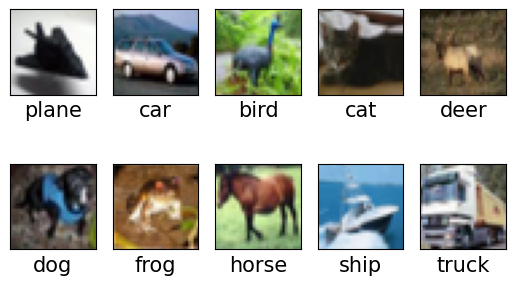

In [5]:
sample_images = [train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)]
fig, axes = plt.subplots(2, 5)
plt.subplots_adjust(top = 0.7)
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i].reshape((32,32,3)))
    i += 1

## Function for loss and accuracy visualization

In [6]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, val_losses, train_accuracies, val_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='val')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

## Implement neural network

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dropout):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, X):
        return self.block(X)

class CustomCNN(nn.Module):
    def __init__(self, in_channels, architecture_config):
        super().__init__()
        self.in_channels = in_channels
        self.architecture_config = architecture_config
        self.conv_layers = self._create_conv_layers(self.architecture_config[0])
        self.fcl = self._create_fcl(self.architecture_config[1])

    def forward(self, X):
        X = self.conv_layers(X)
        X = nn.Flatten(1)(X)
        X = self.fcl(X)
        return X

    def _create_conv_layers(self, architecture_config):
        in_channels = self.in_channels
        layers = []

        for x in architecture_config:
            if type(x) == tuple:
                layers += [
                    ConvBlock(in_channels, x[1], x[0], x[2])
                ]
                in_channels = x[1]
            else:
                layers += [
                    nn.MaxPool2d(kernel_size=2)
                ]

        return nn.Sequential(*layers)

    def _create_fcl(self, architecture_config):
        layers = []

        for x in architecture_config:
            if type(x) == tuple:
                layers += [
                    nn.Linear(x[0], x[1])
                ]
            else:
                layers += [
                    nn.ReLU()
                ]

        return nn.Sequential(*layers)

## Learning cycle

In [8]:
def train(model, criterion, optimizer, train_loader, val_loader, scheduler=None, n_epochs=5):
    torch.manual_seed(42)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    best_model = None
    best_accuracy = 0.0

    for epoch in range(n_epochs):
        train_loss, train_accuracy = 0.0, 0.0
        model.train()
        for imgs, labels in tqdm(train_loader, desc='Training'):
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
            train_accuracy += torch.sum(torch.argmax(logits.cpu(), dim=1) == labels.cpu()).item()

        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        val_loss, val_accuracy = 0.0, 0.0
        model.eval()
        for imgs, labels in tqdm(val_loader, desc='Validating'):
            imgs = imgs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(imgs)
                loss = criterion(logits, labels)

            val_loss += loss.item()
            val_accuracy += torch.sum(torch.argmax(logits.cpu(), dim=1) == labels.cpu()).item()

        val_loss /= len(val_loader)

        if scheduler is not None:
            scheduler.step(val_loss)

        val_accuracy /= len(val_loader.dataset)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = copy.deepcopy(model)

        val_losses += [val_loss]
        val_accuracies += [val_accuracy]

        plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)

    return torch.min(torch.tensor(val_losses)).item(), best_accuracy, best_model

## Architecture config

In [11]:
architecture_config = [
    # Convolutional layers.
    [
        (3, 128, 0), # kernel_size x out_channels x dropout.
        "M", # Maxpool.
        (3, 256, 0.3),
        "M",
    ],
    # Fully connected layers.
    [
        (256 * 8 * 8, 512), # in_features x out_features
        "R", # ReLU
        (512, 1024),
        "R",
        (1024, 10)
    ]
]

## Tuning hyperparameters

Let's try sgd optimizer with ReduceLROnPlateau scheduler:

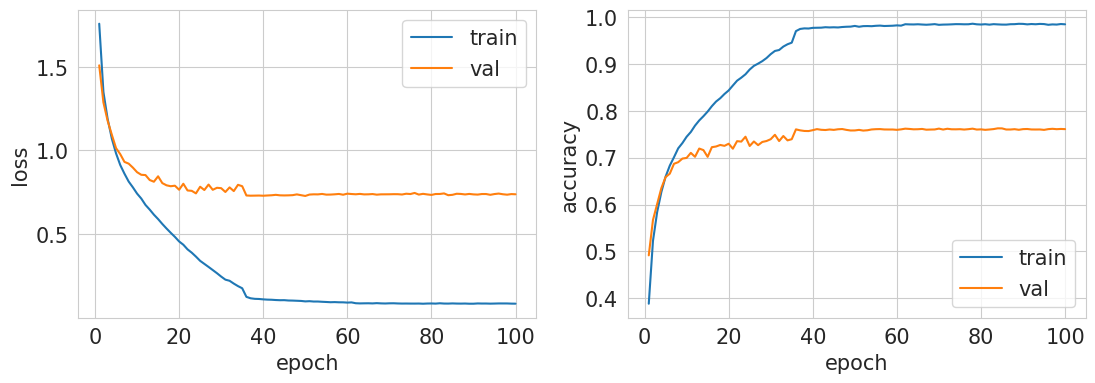

In [14]:
torch.manual_seed(42)
NUM_EPOCHS = 100
momentum = 0.9
lr = 1e-4

model = CustomCNN(3, architecture_config).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
best_val_loss, best_val_accuracy, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, n_epochs=NUM_EPOCHS)

In [16]:
torch.save(best_model.cpu().state_dict(), "saved_models/model_sgd.pth")

In [17]:
best_val_loss, best_val_accuracy

(0.7281892895698547, 0.7627)

Adding weight decay:

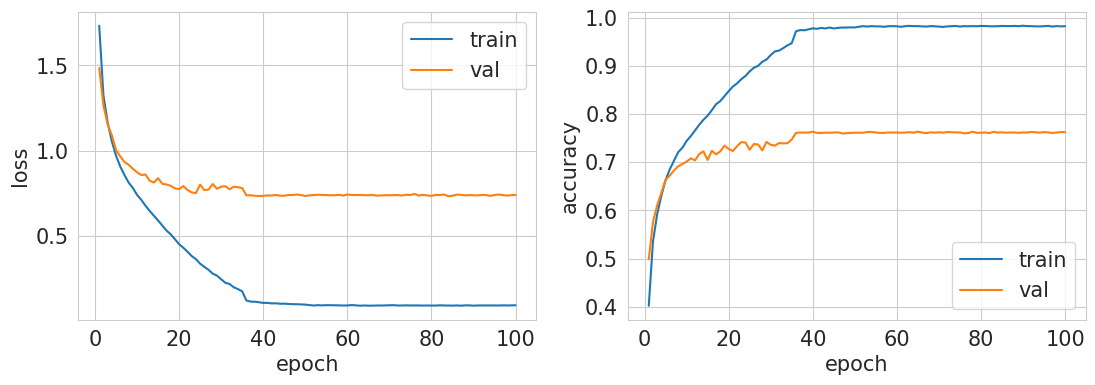

In [33]:
torch.manual_seed(42)
NUM_EPOCHS = 100
momentum = 0.9
lr = 1e-4

model = CustomCNN(3, architecture_config).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=lr, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
best_val_loss, best_val_accuracy, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, n_epochs=NUM_EPOCHS)

In [34]:
torch.save(best_model.cpu().state_dict(), "saved_models/model_sgd_wd=1e-6.pth")

In [35]:
best_val_loss, best_val_accuracy

(0.7335821390151978, 0.7635)

It's a little better, but the difference is barely noticeable.<br>
Let's try CosineAnnealingLR:

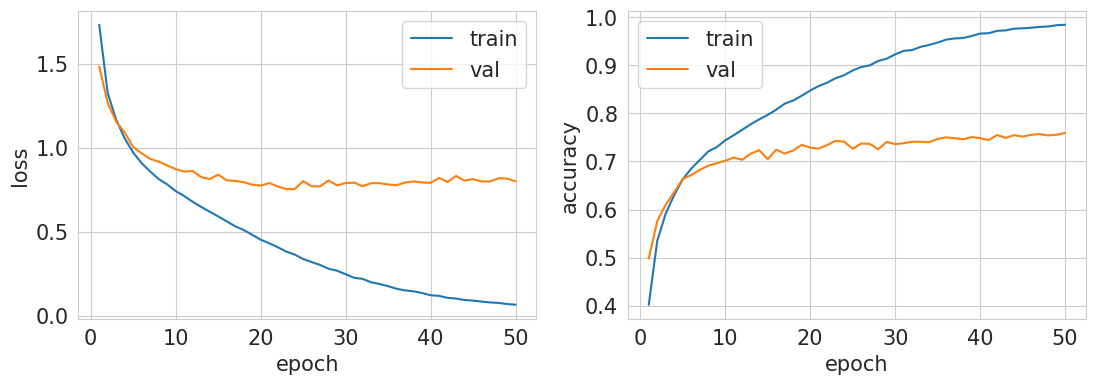

In [36]:
torch.manual_seed(42)
NUM_EPOCHS = 50
momentum = 0.9
lr = 1e-4

model = CustomCNN(3, architecture_config).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=lr, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
best_val_loss, best_val_accuracy, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, n_epochs=NUM_EPOCHS)

In [37]:
torch.save(best_model.cpu().state_dict(), "saved_models/model_sgd,wd=1e-6,cosinLR.pth")

In [38]:
best_val_loss, best_val_accuracy

(0.7537512183189392, 0.7591)

## Estimate model on test data.

In [39]:
m = CustomCNN(3, architecture_config)
m.load_state_dict(torch.load('saved_models/model_sgd_wd=1e-6.pth'))
m = m.to(device)

In [40]:
test_loss, test_accuracy = 0.0, 0.0

m.eval()
for imgs, labels in tqdm(test_dataloader, desc='Testing'):
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = m(imgs)
        loss = criterion(logits, labels)

    test_loss += loss.item()
    test_accuracy += torch.sum(torch.argmax(logits.cpu(), dim=1) == labels.cpu()).item()

test_loss /= len(test_dataloader)
test_accuracy /= len(test_dataloader.dataset)
test_loss, test_accuracy

Testing: 100%|██████████| 313/313 [00:05<00:00, 58.44it/s]


(0.7420839759678887, 0.762)